In [74]:
import pandas as pd
import numpy as np
import torch
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
from collections import Counter
import pickle as pkl
import random
import re
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import os 

import matplotlib.pyplot as plt
from functools import partial
from PIL import Image

In [75]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [76]:
image_data_path = '../data/images'
image_filename_list = os.listdir(image_data_path)

In [77]:
'0d98dec488_main.jpg' in image_filename_list

True

In [78]:
data_recipe = pd.read_csv('../data/cleaned_recipe_data.csv', index_col=0)

In [79]:
get_id = lambda x: x[:-9]
id2imageFile_dict = dict(zip(list(map(get_id, image_filename_list)), image_filename_list))

In [80]:
id2imageFile = pd.Series(id2imageFile_dict, name='image_filename')
id2imageFile.index.name = data_recipe.index.name
id2imageFile = pd.DataFrame(id2imageFile)

In [81]:
data_recipe_with_image = pd.merge(data_recipe, id2imageFile, how='outer', left_index=True, right_index=True)

In [82]:
data_recipe_with_image.columns

Index(['title', 'subtitle', 'carbs', 'fat', 'protein', 'chef_id', 'calories',
       'cooking_tips', 'story', 'ingredients_display', 'step_one', 'step_two',
       'step_three', 'step_four', 'step_five', 'step_six', 'recipe_tags',
       'tag_cuisine_african', 'tag_cuisine_mexican',
       'tag_cuisine_middle-eastern', 'tag_cuisine_latin-american',
       'tag_cuisine_french', 'tag_cuisine_italian', 'tag_cuisine_nordic',
       'tag_cuisine_american', 'tag_cuisine_asian',
       'tag_cuisine_mediterranean', 'tag_cuisine_indian',
       'tag_cuisine_european', 'image_filename'],
      dtype='object')

In [83]:
data_recipe_image = data_recipe_with_image[['image_filename','tag_cuisine_african', 'tag_cuisine_mexican',
                                            'tag_cuisine_middle-eastern', 'tag_cuisine_latin-american', 
                                            'tag_cuisine_french', 'tag_cuisine_italian', 'tag_cuisine_nordic', 
                                            'tag_cuisine_american', 'tag_cuisine_asian','tag_cuisine_mediterranean',
                                            'tag_cuisine_indian', 'tag_cuisine_european']]

In [84]:
print(len(data_recipe), len(id2imageFile), len(data_recipe_image))

2508 2549 2561


In [85]:
data_recipe_image[(data_recipe_image['image_filename']).isnull()]

,image_filename,tag_cuisine_african,tag_cuisine_mexican,tag_cuisine_middle-eastern,tag_cuisine_latin-american,tag_cuisine_french,tag_cuisine_italian,tag_cuisine_nordic,tag_cuisine_american,tag_cuisine_asian,tag_cuisine_mediterranean,tag_cuisine_indian,tag_cuisine_european
external_id,,,,,,,,,,,,,
1.07E+60,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.83E+24,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
188599912,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1a14372b9e,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2.49E+09,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
357057987,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4.31E+29,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7.12E+155,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.92E+15,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
data_recipe_image = data_recipe_image.dropna(how='any')

In [87]:
RANDOM_STATE = 42
train_data, test= train_test_split(data_recipe_image, test_size=0.1, random_state=RANDOM_STATE)
val_data, test_data = train_test_split(test, test_size=0.1, random_state=RANDOM_STATE)

In [88]:
shape_list = [] 
for item in data_recipe_image['image_filename'].values:
    try:
        aa = Image.open(image_data_path+'/'+item).convert('RGB')
        bb = tv.transforms.functional.to_tensor(aa)
        shape_list.append(bb.shape)   
    except:
        print(item)

00d850d6ba_main.jpg
021570bfb3_main.jpg
029ba93fcd_main.jpg
032b185bb8_main.jpg
0d98dec488_main.jpg
0e6f9ff604_main.jpg
144c30efd3_main.jpg
15947909ae_main.jpg
15f67867cc_main.jpg
19961b58a5_main.jpg
1b131c638a_main.jpg
1b8709209e_main.jpg
1daa035ae8_main.jpg
217d46cf09_main.jpg
2845c3d200_main.jpg
28b00c76a3_main.jpg
2c809b59c3_main.jpg
3309275dd0_main.jpg
34bcb824b7_main.jpg
364f273ac3_main.jpg
39552a57f1_main.jpg
3c6a52a1d0_main.jpg
3c8418c43c_main.jpg
3d823793da_main.jpg
3d8cfaaab6_main.jpg
411968adb2_main.jpg
425d3956d8_main.jpg
428266541c_main.jpg
44628149f0_main.jpg
44f9178e15_main.jpg
4763298fb9_main.jpg
49173b5e5d_main.jpg
493ac4c6db_main.jpg
4dbecd67d9_main.jpg
525491b44e_main.jpg
5326492227_main.jpg
56914d2c9c_main.jpg
59e6cb3eee_main.jpg
5cf4453cf6_main.jpg
5f3b1a10b9_main.jpg
6278d04e0d_main.jpg
65df1ea95a_main.jpg
6fac3015c7_main.jpg
70a5cdfbb2_main.jpg
739be22caa_main.jpg
76b620ec3b_main.jpg
77403a4517_main.jpg
79ee4aad8a_main.jpg
7cbcd3331b_main.jpg
82e89664c0_main.jpg


In [95]:
data_recipe_image['image_filename'].values.shape

(2496,)

In [83]:
aa = Image.open(image_data_path+'/'+data_recipe_image['image_filename'].iloc[2])

In [84]:
aa = aa.convert('RGB')

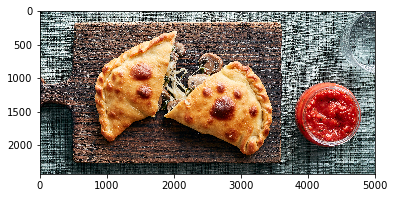

In [85]:
plt.imshow(aa)
plt.show()

In [86]:
bb = tv.transforms.functional.to_tensor(aa)

In [87]:
bb.shape

torch.Size([3, 2429, 5000])

In [90]:
aa1 = tv.transforms.functional.resize(aa,size=(256,256*2))

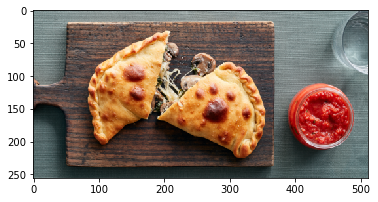

In [91]:
plt.imshow(aa1)
plt.show()

In [28]:
bb1 = tv.transforms.functional.to_tensor(aa1)

In [30]:
bb1.shape

torch.Size([3, 400, 823])

In [48]:
def load_image(image_path):
    try:
        image = Image.open(image_data_path+'/'+image_path).convert('RGB')
    except:
        image = Image.open(image_data_path+'/'+'004a778a05_main.jpg').convert('RGB')
    return image

normalize = tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform_image = tv.transforms.Compose([
    tv.transforms.RandomResizedCrop(224),
    #tv.transforms.Resize((256,256)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    normalize,])
# def transform_image(image_path):
#     ''' read image, preprocess (sampling, normalization) and to tensor
#     '''
#     image = Image.open(image_data_path+'/'+image_path).convert('RGB')
#     image = tv.transforms.functional.resize(image,size=(300,600))
#     image_tensor = tv.transforms.functional.to_tensor(image)
#     return image_tensor

In [104]:
def load_image_dataset(data):
    data_processed = []
    for item in data.values:
        data_processed.append(load_image(item))
    return data_processed

train_data_img = load_image_dataset(train_data['image_filename'])
val_data_img = load_image_dataset(val_data['image_filename'])
test_data_img = load_image_dataset(test_data['image_filename'])

In [49]:
class ImageDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, train_data_img, tags, load_image, transform_image):
        """
        
        @param data_list: list of recipie tokens 
        @param target_list: list of single tag, i.e. 'tag_cuisine_american'

        """
        self.data_arr = train_data_img.values
        self.tags_arr = tags.values
        self.load = load_image
        self.transform = transform_image
        assert (len(self.data_arr) == len(self.tags_arr))

    def __len__(self):
        return len(self.data_arr)
        
    def __getitem__(self, key):
        """
        Triggered when  you call recipie[i]
        """
        image = self.transform(self.load(self.data_arr[key]))
        label = self.tags_arr[key]
        return (image, label)

def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    images = []
    labels = []
    for datum in batch:
        images.append(datum[0])
        labels.append(datum[1])
    images = np.stack(images, axis=0)
    
    return [torch.from_numpy(images).to(device), torch.LongTensor(labels).to(device)]

In [50]:
# Build train, valid and test dataloaders
def create_dataset_obj(train,val,test,train_targets,val_targets,test_targets,
                       load_image,transform_image,batch_size,collate_func):
    train_dataset = ImageDataset(train, train_targets, load_image, transform_image)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               collate_fn=collate_func,
                                               shuffle=True)

    val_dataset = ImageDataset(val, val_targets, load_image, transform_image)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                             batch_size=batch_size,
                                             collate_fn=collate_func,
                                             shuffle=False)

    test_dataset = ImageDataset(test, test_targets, load_image, transform_image)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=batch_size,
                                               collate_fn=collate_func,
                                               shuffle=False)
    return train_loader, val_loader, test_loader

In [70]:
class Image_CNN(nn.Module):
    def __init__(self, num_classes):
        
        super(Image_CNN, self).__init__()
        resnet = tv.models.resnet50(pretrained=True)
        resnet_modules = list(resnet.children())[:-1]
        self.resnet50 = nn.Sequential(*resnet_modules)
        self.linear = nn.Linear(2048, num_classes)


    def forward(self, img):
        hidden = self.resnet50(img)
        hidden = torch.squeeze(hidden)
        print(hidden.size())
        logits = self.linear(hidden)
        return logits

from sklearn.metrics import roc_auc_score
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    logits_all = []
    labels_all = []
    model.eval()
    for image_batch, labels_batch in loader:
        logits = model(image_batch)
        logits_all.extend(list(logits.cpu().detach().numpy()))
        labels_all.extend(list(labels_batch.cpu().numpy()))
    logits_all = np.array(logits_all)
    labels_all = np.array(labels_all)
    auc = roc_auc_score(labels_all, logits_all)
    predicts = (logits_all > 0.5).astype(int)
    acc = np.mean(predicts==labels_all)
    return auc, acc

In [71]:
params = dict(
    num_classes = 1,
    
    num_epochs = 2,
    batch_size = 50,
    learning_rate = 0.01,
)

In [72]:
batch_size = params['batch_size']
train,val,test = train_data['image_filename'], val_data['image_filename'], test_data['image_filename']
tag_predicted = 'tag_cuisine_american'
train_targets,val_targets,test_targets = train_data[tag_predicted], val_data[tag_predicted], test_data[tag_predicted]
train_loader, val_loader, test_loader = create_dataset_obj(train,val,test,train_targets,
                                                           val_targets,test_targets,
                                                           load_image,transform_image,
                                                           batch_size,collate_func)

In [ ]:
#build model
num_classes = params['num_classes']
batch_size = params['batch_size']

model = Image_CNN(num_classes)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print('The number of train parameters', sum([np.prod(p.size()) for p in model_parameters]))
model = model.to(device)

#parameter for training
learning_rate = params['learning_rate']
num_epochs = params['num_epochs'] # number epoch to train

# Criterion and Optimizer
#pos_weight=torch.Tensor([40,]).cuda()
criterion = nn.BCEWithLogitsLoss() #torch.nn.BCELoss(); torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss_list = []

for epoch in range(num_epochs):
    for i, (image_batch, labels_batch) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        outputs = model(image_batch)
        loss = criterion(outputs, labels_batch.view(-1,1).float()) 
        train_loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i % 10 == 0:
            # validate
#             print('---------------------')
#             for p in model.parameters():
#                 if p.requires_grad:
#                     print(p.name, p.size(), p.requires_grad, torch.mean(torch.abs(p.data)), torch.mean(torch.abs(p.grad)))
#                     break
            val_auc, val_acc = test_model(val_loader, model)
            print('{}/{}, Step:{}/{}, TrainLoss:{:.6f}, ValAUC:{:.6f} ValAcc:{:.6f}'.format(
                epoch+1, num_epochs, i+1, len(train_loader), loss, val_auc, val_acc))
    val_auc, val_acc = test_model(val_loader, model)
    train_auc, train_acc = test_model(train_loader, model)
    print('Epoch: [{}/{}], trainAUC: {:.6f}, trainAcc: {:.6f}'.format(epoch+1, num_epochs, train_auc, train_acc))
    print('Epoch: [{}/{}], ValAUC: {:.6f}, ValAcc: {:.6f}'.format(epoch+1, num_epochs, val_auc, val_acc))

The number of train parameters 23510081
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([25, 2048])
1/2, Step:1/45, TrainLoss:0.759586, ValAUC:0.426911 ValAcc:0.706667
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([25, 2048])
1/2, Step:11/45, TrainLoss:0.579377, ValAUC:0.544406 ValAcc:0.706667
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([50, 2048])
torch.Size([25, 20

In [55]:
resnet = tv.models.resnet50(pretrained=True)
resnet_modules = list(resnet.children())

In [58]:
print(resnet_modules)

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_